# Astronomical Image Reconstruction using Autoencoder
We will demonstrate image reconstruction of images of galaxies in Messier Catalog using Autoencoder. De-noising autoencoders can be trained for deconvolution and removal of noise.

In [1]:
from mirapy.data.load_dataset import load_messier_catalog_images, prepare_messier_catalog_images
from mirapy.utils import get_psf_airy, image_augmentation, append_one_to_shape, psnr
from mirapy.autoencoder.models import DeNoisingAutoencoder

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
import numpy as np
import scipy

Using TensorFlow backend.


In [2]:
data_dir = '../../image-denoising-network/messier_catalog_galaxies'
img_dim = (256, 256)

npsf=64
nr=5

sigma=0.1

We will load the data set and reshape it to 256x256.

In [3]:
images = load_messier_catalog_images(data_dir, img_dim)

100%|██████████| 39/39 [00:10<00:00,  3.72it/s]


We have 39 images in total. Firstly, we will take 4 test images and apply various data augmentation to increase the size of training set.

In [4]:
X_train, X_test = train_test_split(images, test_size=0.10, random_state=42)

In [5]:
datagen = ImageDataGenerator(rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True)

X_train = image_augmentation(X_train, datagen, 20)

100%|██████████| 35/35 [00:02<00:00, 13.43it/s]


Following is the PSF function used for convolution:

```
def get_psf_airy(n, nr):
    xpsf = np.linspace(-1, 1, n)
    xg, yg = np.meshgrid(xpsf, xpsf)
    r = np.sqrt(xg**2+yg**2)*np.pi*nr
    psf = (scipy.special.j1(r)/r)**2
    psf = psf/psf.sum()
    return psf
```

You can also import it from `mirapy.utils` module.

In [7]:
psf = get_psf_airy(npsf, nr)

It is time to prepare datasets by applying convolution and adding noise from Poisson distribution.

In [8]:
X_train, x_train_noisy = prepare_messier_catalog_images(X_train, psf=psf, sigma=sigma)
X_test, x_test_noisy = prepare_messier_catalog_images(X_test, psf=psf, sigma=sigma)

We reshape the image to append `1` that represents the grayscale channel.

In [9]:
X_train = append_one_to_shape(X_train)
X_test = append_one_to_shape(X_test)
x_train_noisy = append_one_to_shape(np.array(x_train_noisy))
x_test_noisy = append_one_to_shape(np.array(x_test_noisy))

We are done with data pre-processing of images! Now it's time to build the autoencoder model. We can tune parameters to see how the network performs.

In [10]:
autoencoder = DeNoisingAutoencoder(img_dim, 'relu', 'same')

Following are the four examples of input and output images.

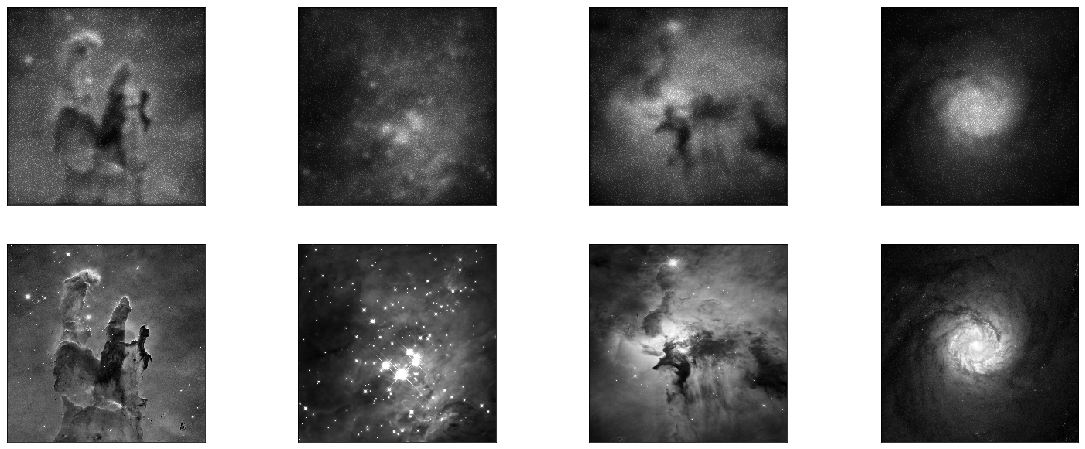

In [11]:
autoencoder.show_image_pairs(x_test_noisy, X_test, 4)

We will use `Adam` optimizer class in Keras and mean squared error as the loss function.

In [12]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
autoencoder.compile(adam, 'mean_squared_error')

Here, we will use the noisy and original images of test set for validation.

In [13]:
autoencoder.train(x_train_noisy, X_train, epochs=10, validation_data=(x_test_noisy, X_test), verbose=2)

Train on 700 samples, validate on 4 samples
Epoch 1/10
 - 25s - loss: 0.0354 - val_loss: 0.0190
Epoch 2/10
 - 16s - loss: 0.0139 - val_loss: 0.0079
Epoch 3/10
 - 16s - loss: 0.0079 - val_loss: 0.0140
Epoch 4/10
 - 16s - loss: 0.0057 - val_loss: 0.0675
Epoch 5/10
 - 16s - loss: 0.0033 - val_loss: 0.0114
Epoch 6/10
 - 16s - loss: 0.0032 - val_loss: 0.0050
Epoch 7/10
 - 16s - loss: 0.0033 - val_loss: 0.0044
Epoch 8/10
 - 16s - loss: 0.0027 - val_loss: 0.0041
Epoch 9/10
 - 17s - loss: 0.0030 - val_loss: 0.0046
Epoch 10/10
 - 16s - loss: 0.0030 - val_loss: 0.0052


Now, we will denoise the test images and show the results:

In [15]:
decoded_imgs = autoencoder.predict(x_test_noisy)

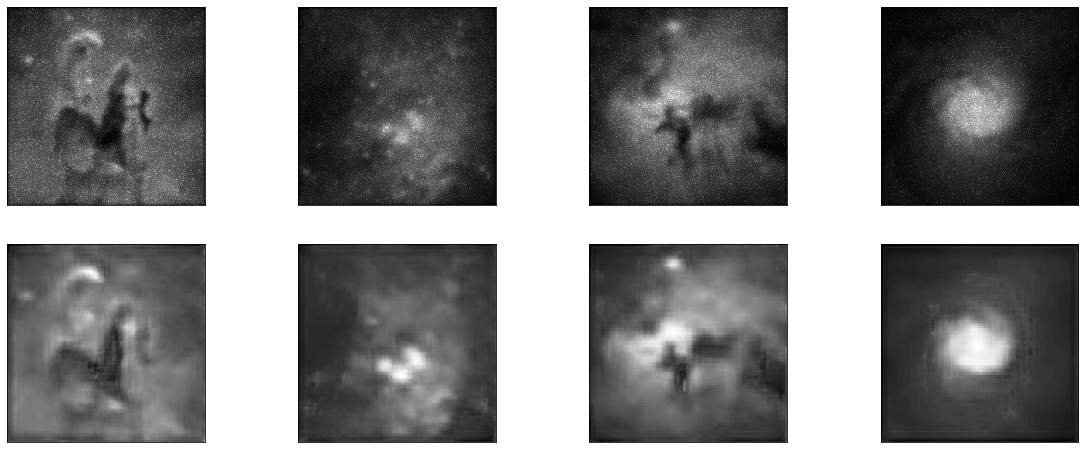

In [16]:
autoencoder.show_image_pairs(x_test_noisy, decoded_imgs, 4)

We will compute peak signal to noise ratio (PSNR) for an image:

In [17]:
psnr(x_test_noisy[0], decoded_imgs[0])

22.607261013959153

# Comparing results
It is time to compare our result with:

- Wiener-Hunt deconvolution
- Richardson-Lucy deconvolution
- Total-variation denoising

In [18]:
from skimage import color, data, restoration

/home/swapsha96/anaconda3/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [19]:
nimg = x_test_noisy[0].reshape((256, 256))
decoded_rl = restoration.richardson_lucy(nimg, get_psf_airy(npsf, nr), 2)
decoded_w = restoration.wiener(nimg, get_psf_airy(npsf, nr), 1100)
decoded_tv = restoration.denoise_tv_chambolle(nimg, 5, n_iter_max=100, eps=0.002, multichannel=False)

d_rl = psnr(x_test_noisy[0], decoded_rl)
d_w = psnr(x_test_noisy[0], decoded_w)
d_tv = psnr(x_test_noisy[0], decoded_tv)
d = psnr(x_test_noisy[0], decoded_imgs[0])

In [20]:
d_rl, d_w, d_tv, d

(16.557517526111557, 17.166157498605262, 17.0596991093371, 22.607261013959153)

Here, we see that our proposed model outperforms the results of standard image restoration techniques!